In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [163]:
path='C:/Users/shaur/Desktop/CV Projects/Time Series Project/Time_Series_Covid_19_Project/data/'
df=pd.read_csv(path+'covid_19_global_data.csv')

In [164]:
df.columns

Index(['Id', 'County', 'Province_State', 'Country_Region', 'Population',
       'Weight', 'Date', 'Target', 'TargetValue'],
      dtype='object')

### Let us do some data engineering

In [165]:
df.Date =  pd.to_datetime(df['Date']) 

In [166]:
df_c=df[df.Target=='ConfirmedCases']
df_f=df[df.Target=='Fatalities']

In [167]:
map_df_c=pd.DataFrame(df_c[['Country_Region','TargetValue']].groupby('Country_Region')['TargetValue'].sum()).reset_index().sort_values(by='TargetValue',ascending=False)
map_df_f=pd.DataFrame(df_f[['Country_Region','TargetValue']].groupby('Country_Region')['TargetValue'].sum()).reset_index().sort_values(by='TargetValue',ascending=False)
# merge two dataframes
map_df_merge=pd.merge(map_df_c,map_df_f,on='Country_Region')
map_df_merge.columns=['Country_Region','Confirmed_Cases','Fatalities']

In [168]:
import pycountry
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE 

In [169]:
map_df_merge['CODE']=alpha3code(map_df_merge.Country_Region)
map_df_merge.head(10)

Country_Region  Confirmed_Cases  Fatalities  CODE
0              US        4970430.0    293387.0  None
1          Brazil         374898.0     23473.0   BRA
2          Russia         353427.0      3633.0  None
3  United Kingdom         262547.0     36996.0   GBR
4           Spain         235400.0     26834.0   ESP
5           Italy         230158.0     32877.0   ITA
6          France         183067.0     28460.0   FRA
7         Germany         180600.0      8309.0   DEU
8          Canada         174210.0     13308.0   CAN
9           China         167108.0      9242.0   CHN

In [170]:
# Check for the country codes not found
not_found_countries=[]
index=[]
for i in range(len(map_df_merge)):
    if map_df_merge.CODE[i] =='None':
        not_found_countries.append(map_df_merge['Country_Region'][i])
        index.append(i)

In [171]:
print(not_found_countries)
print(index)

['US', 'Russia', 'Iran', 'Korea, South', 'Moldova', 'Bolivia', "Cote d'Ivoire", 'Congo (Kinshasa)', 'Venezuela', 'Kosovo', 'Diamond Princess', 'Tanzania', 'Congo (Brazzaville)', 'Taiwan*', 'West Bank and Gaza', 'Vietnam', 'Burma', 'Brunei', 'Syria', 'Laos', 'Holy See', 'MS Zaandam']
[0, 2, 12, 46, 59, 62, 80, 82, 100, 106, 120, 130, 131, 132, 133, 138, 148, 150, 155, 174, 181, 184]


In [172]:
# find corresponding CODE 
found_countries_CODE=['USA','RUS','IRN','KOR','MDA','BOL',"CIV",'COG','VEN','XK','None','TZA','COD'
                     ,'TWN','None','VNM','MM','BRN','SYR','LAO','VAT','None']
for i in range(len(index)):
    map_df_merge.CODE.iloc[index[i]]=found_countries_CODE[i]

In [173]:
map_df_merge.Country_Region[0]='United States'
map_df_merge.isnull().sum()

Country_Region     0
Confirmed_Cases    0
Fatalities         0
CODE               0
dtype: int64

In [174]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
merge=pd.merge(world,map_df_merge,on='CODE')
merge=merge.merge(pd.read_csv(path+'countries_latitude_longitude.csv'),on='name').sort_values(by='Fatalities',ascending=False).reset_index()

### Let's make the World Map

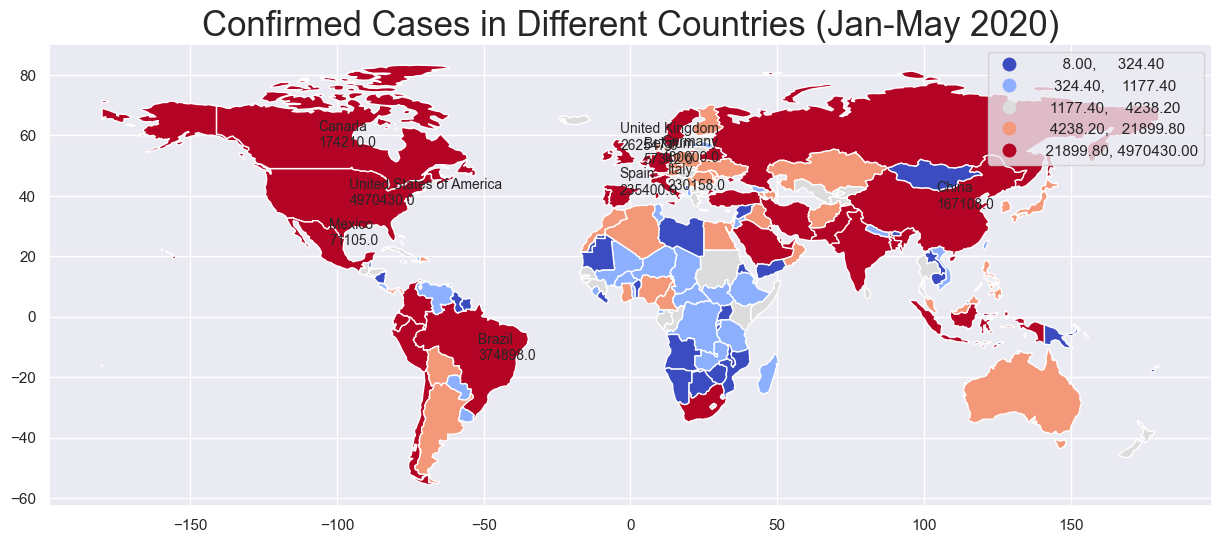

In [178]:
merge.plot(column='Confirmed_Cases', scheme="quantiles",figsize=(15, 20),legend=True,cmap='coolwarm')
plt.title('Confirmed Cases in Different Countries (Jan-May 2020)',fontsize=25)
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge.Confirmed_Cases[i]),size=10)
# plt.show()
plt.savefig("Confirmed Cases in Different Countries (Jan-May 2020)")

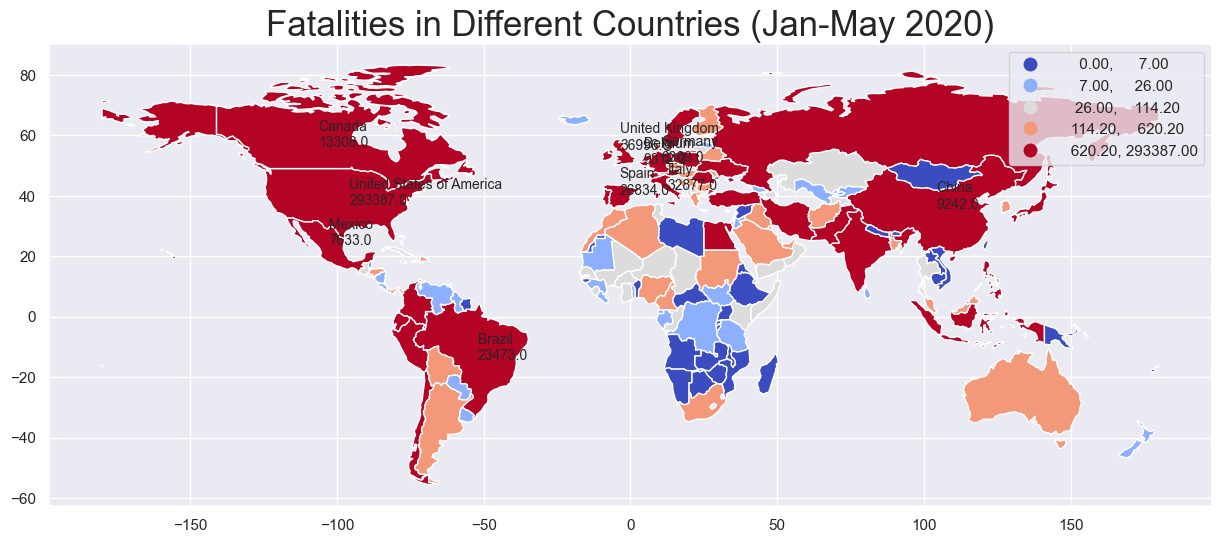

In [179]:
merge.plot(column='Fatalities', scheme="quantiles",figsize=(15, 20),legend=True,cmap='coolwarm')
plt.title('Fatalities in Different Countries (Jan-May 2020)',fontsize=25)
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge.Fatalities[i]),size=10)
# plt.show()
plt.savefig("Fatalities in Different Countries (Jan-May 2020)")

### Let us discuss continental distribution of Covid-19

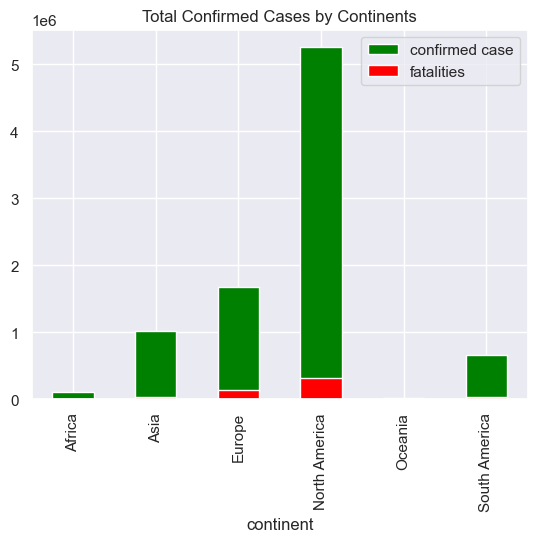

In [180]:
merge.groupby('continent')['Confirmed_Cases'].sum().plot(kind='bar',title='Total Confirmed Cases by Continents',color='green',label='confirmed case')
merge.groupby('continent')['Fatalities'].sum().plot(kind='bar',title='Total Confirmed Cases by Continents',color='red',label='fatalities')
plt.legend()
# plt.show()
plt.savefig("figures/Total Confirmed Cases by Continents")

In [121]:
continent_df=pd.merge(df,merge,on='Country_Region')[[ 'Country_Region', 'Date', 'Target', 'TargetValue','continent']]
continent_list=list(set(continent_df.continent))

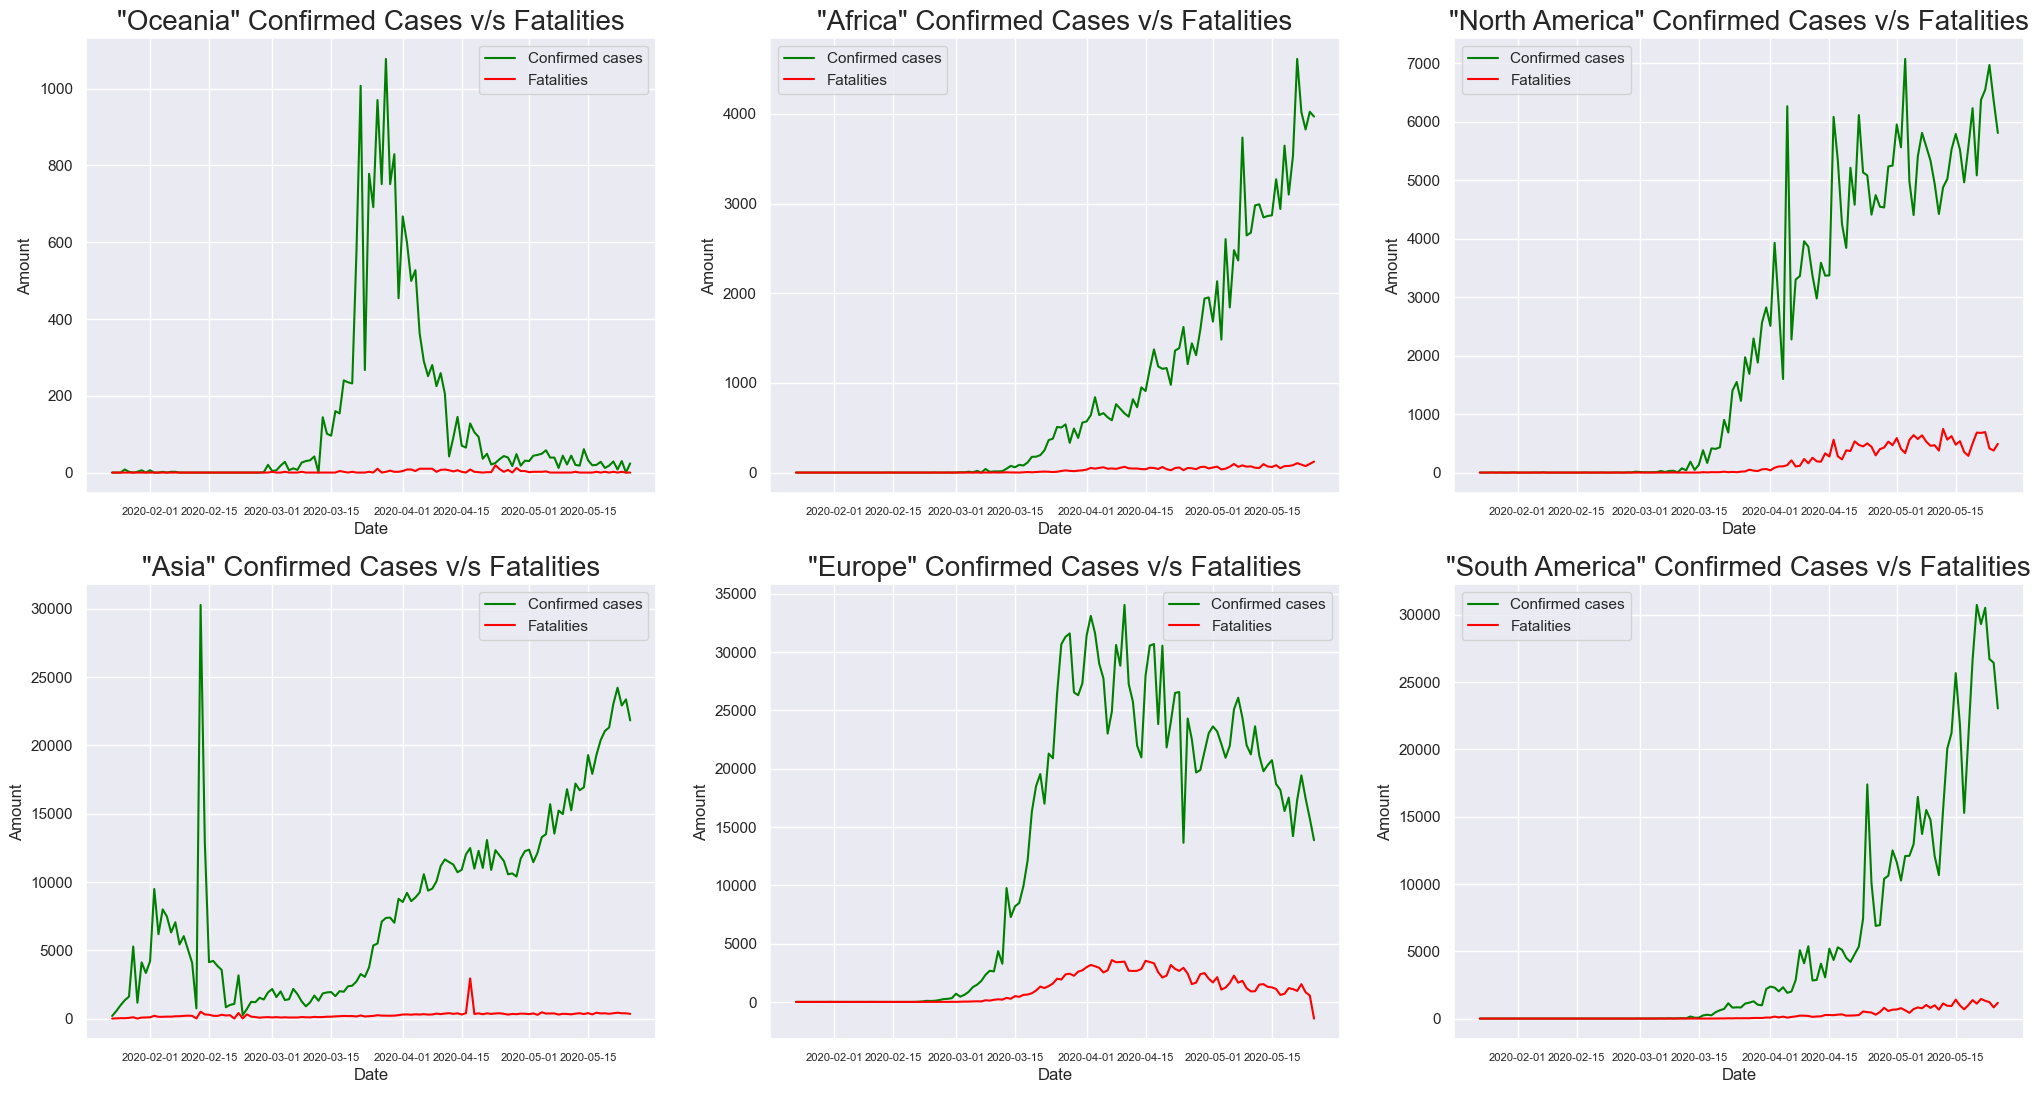

In [197]:
plt.figure(figsize=(25,13))

for i in range(len(continent_list)):
    con_df=continent_df[continent_df.continent==continent_list[i]]
    c=con_df[con_df.Target=="ConfirmedCases"].groupby('Date')['TargetValue'].sum().reset_index()
    f=con_df[con_df.Target=="Fatalities"].groupby('Date')['TargetValue'].sum().reset_index()
    plt.subplot(2,3,i+1)
    sns.lineplot(x=c.Date,y=c.TargetValue,label='Confirmed cases',color='Green')
    sns.lineplot(x=f.Date, y=f.TargetValue,label='Fatalities',color='Red')
    plt.title('\"'+continent_list[i]+'\"'+' Confirmed Cases v/s Fatalities',fontsize=20)
    plt.xticks(size=8)
    plt.ylabel('Amount')
    plt.xlabel('Date')
plt.savefig('figures/continentwise_analysis_lineplot')

### Top 10 countries for Confirmed Cases v/s Fatalities

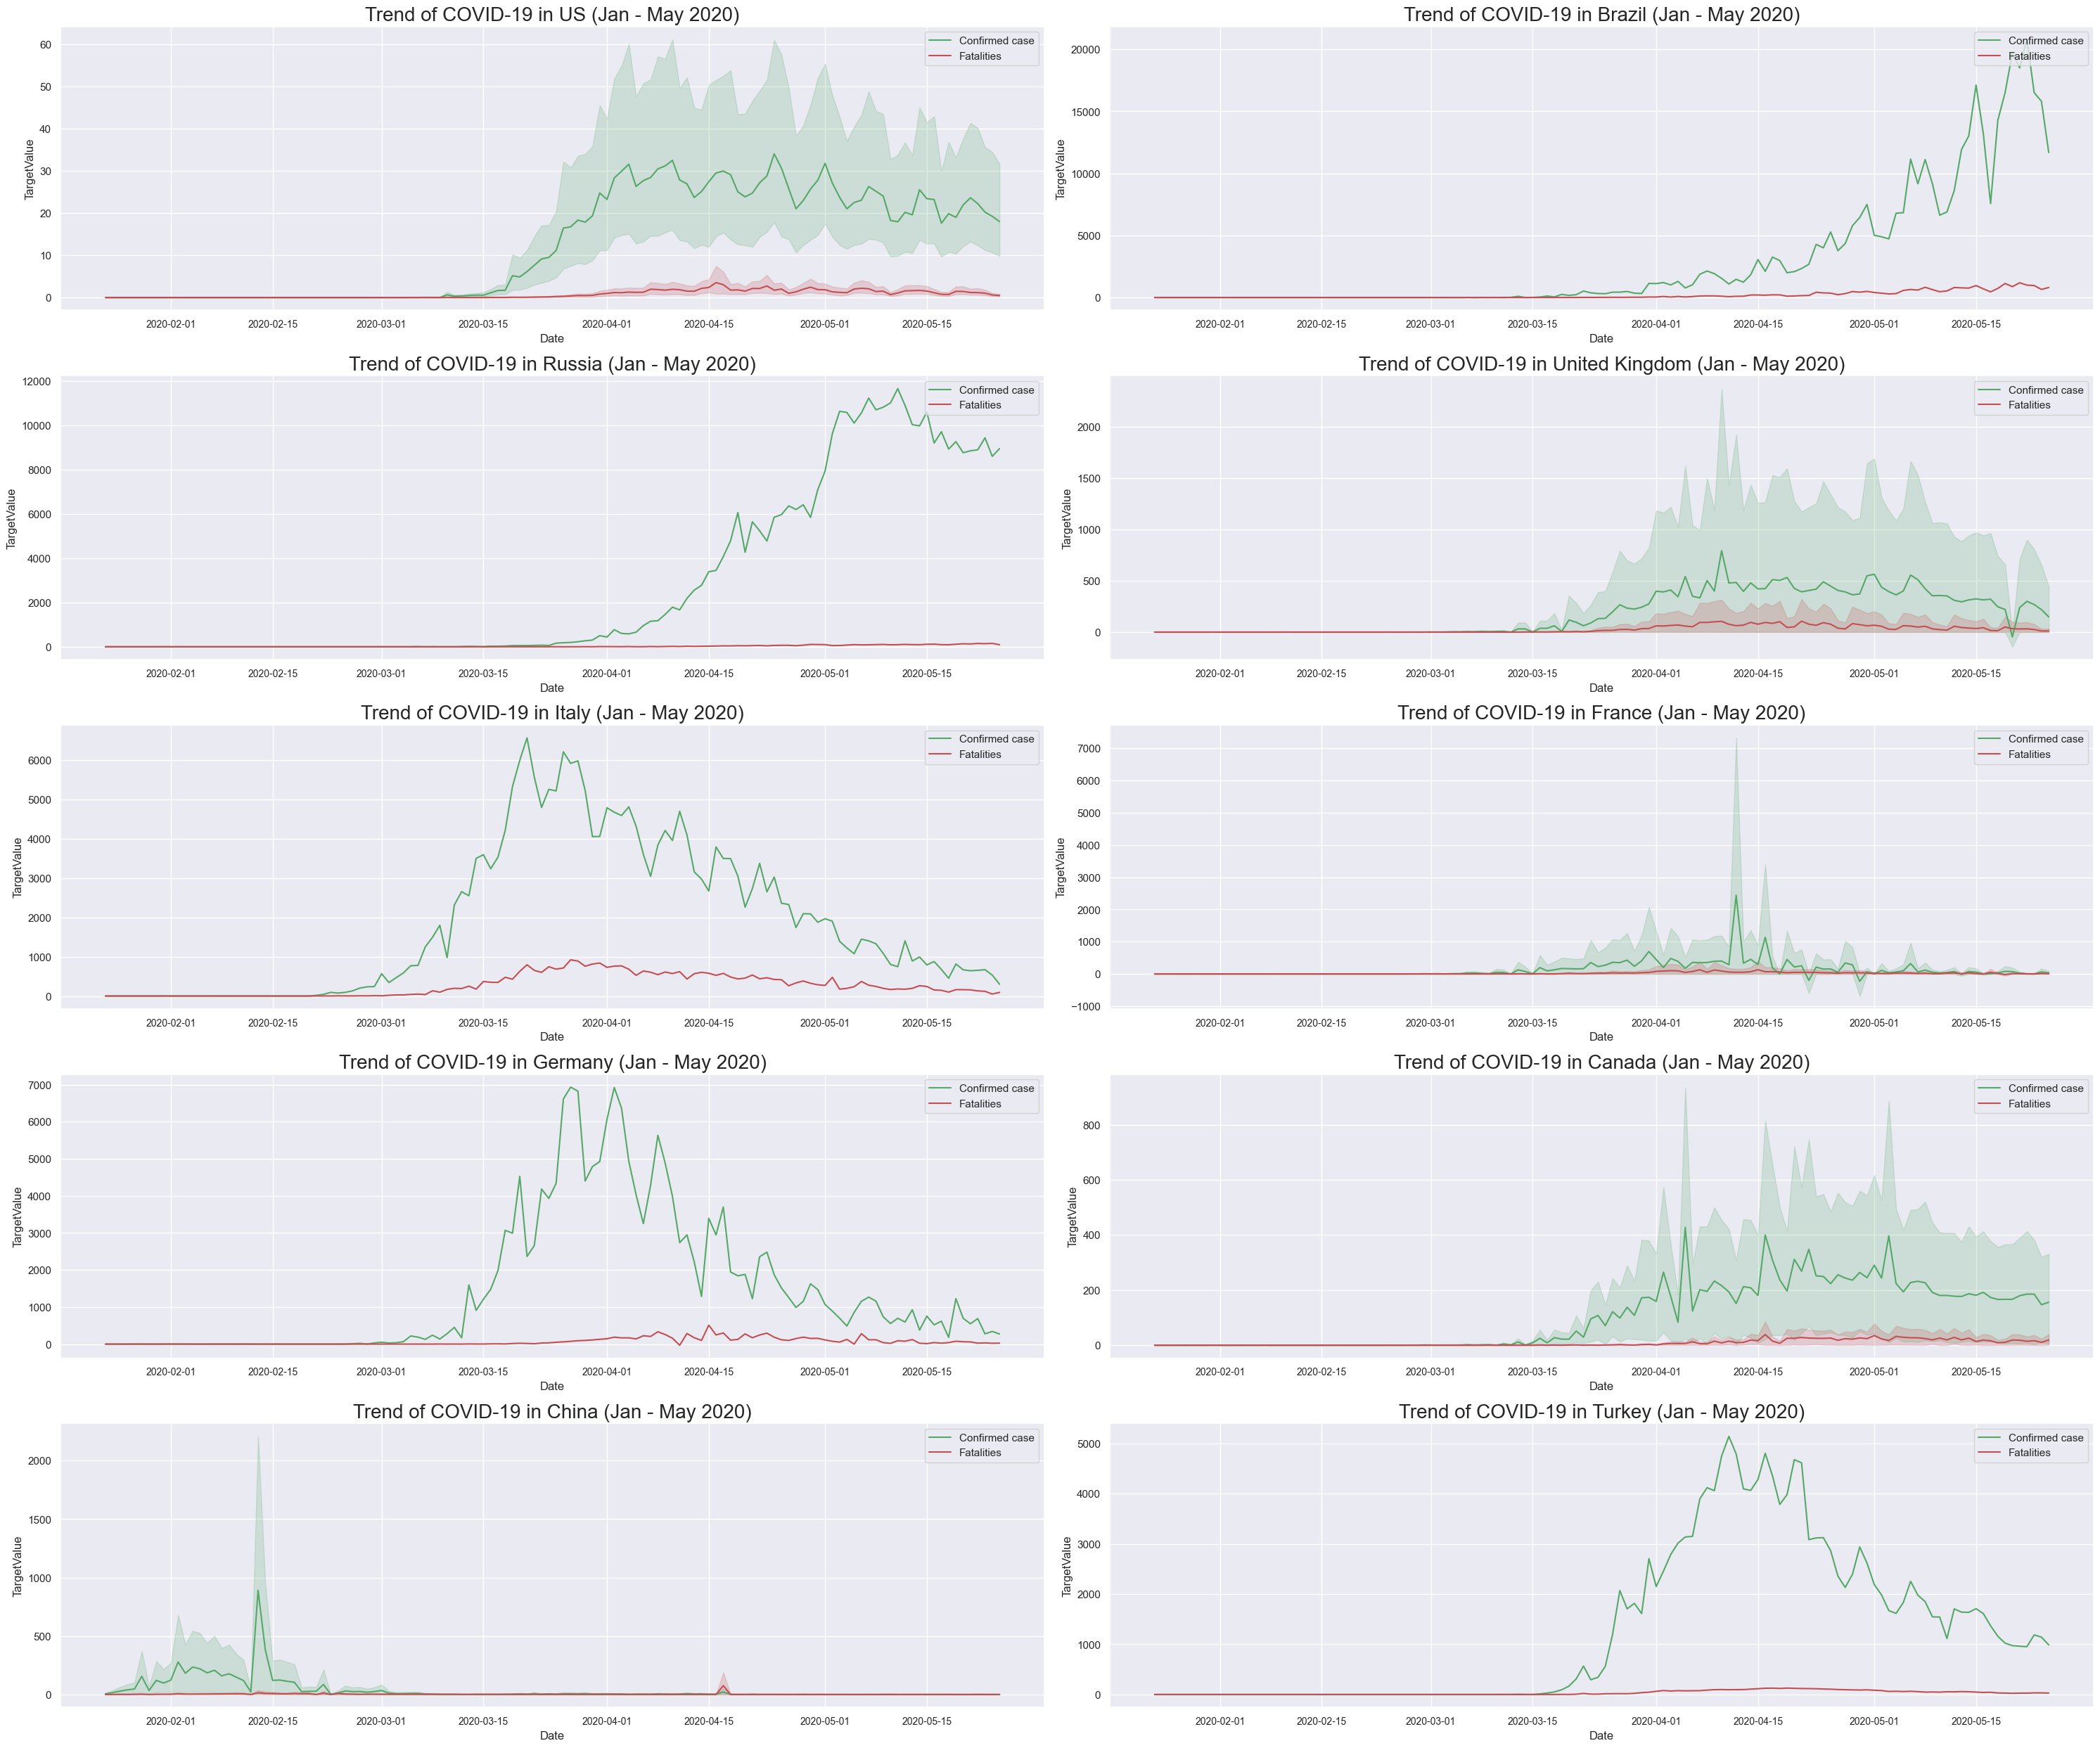

In [195]:
top10_country=['US', 'Brazil', 'Russia', 'United Kingdom', 'Italy', 'France', 'Germany', 'Canada', 'China', 'Turkey']
country_f=df_f[df_f.Country_Region==top10_country[0]]
sum(country_f.TargetValue)
plt.figure(figsize=(30,25))
for i in range(len(top10_country)):
    plt.subplot(5,2,i+1)
    # create dataframes for confirmed cases and fatalities  
    country_c=df_c[df_c.Country_Region==top10_country[i]]
    country_f=df_f[df_f.Country_Region==top10_country[i]]
    # plot using seaborn
    sns.lineplot(x=country_c.Date,y=country_c.TargetValue,color='g',label='Confirmed case')
    sns.lineplot(x=country_f.Date,y=country_f.TargetValue,color='r',label='Fatalities')
    plt.xticks(size=10) 
    plt.legend(loc=1)
    plt.tight_layout(pad=1.0)
    plt.title("Trend of COVID-19 in {} (Jan - May 2020)".format(top10_country[i]),fontsize=20)
plt.savefig('figures/countrywise_analysis_lineplot')

### Let us do a country wise analysis

### USA
##### Overall Analysis of USA

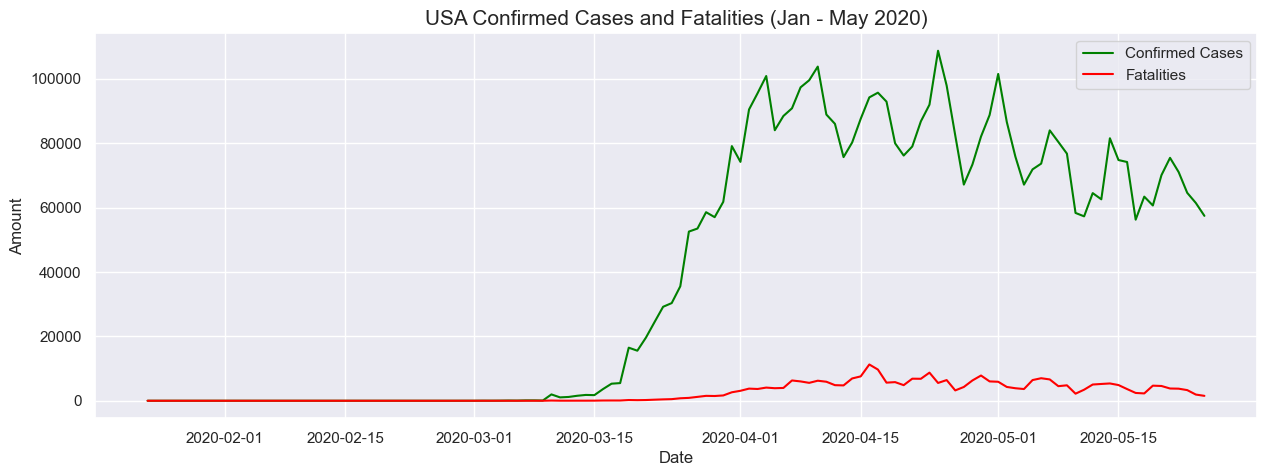

In [196]:
us_confirm=df[df.Country_Region=='US'][df[df.Country_Region=='US'].Target=='ConfirmedCases']
us_death=df[df.Country_Region=='US'][df[df.Country_Region=='US'].Target=='Fatalities']
usa_overall_con=pd.DataFrame(us_confirm.groupby('Date')['TargetValue'].sum()).reset_index()
usa_overall_fa=pd.DataFrame(us_death.groupby('Date')['TargetValue'].sum()).reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(x=usa_overall_con.Date,y=usa_overall_con.TargetValue,label='Confirmed Cases',color='green')
sns.lineplot(x=usa_overall_fa.Date,y=usa_overall_fa.TargetValue,label='Fatalities',color='red')
plt.legend()
plt.ylabel('Amount')
plt.title('USA Confirmed Cases and Fatalities (Jan - May 2020)',fontsize=15)
# plt.show()
plt.savefig("figures/USA Confirmed Cases and Fatalities (Jan - May 2020)")

#### State wise Analysis of USA

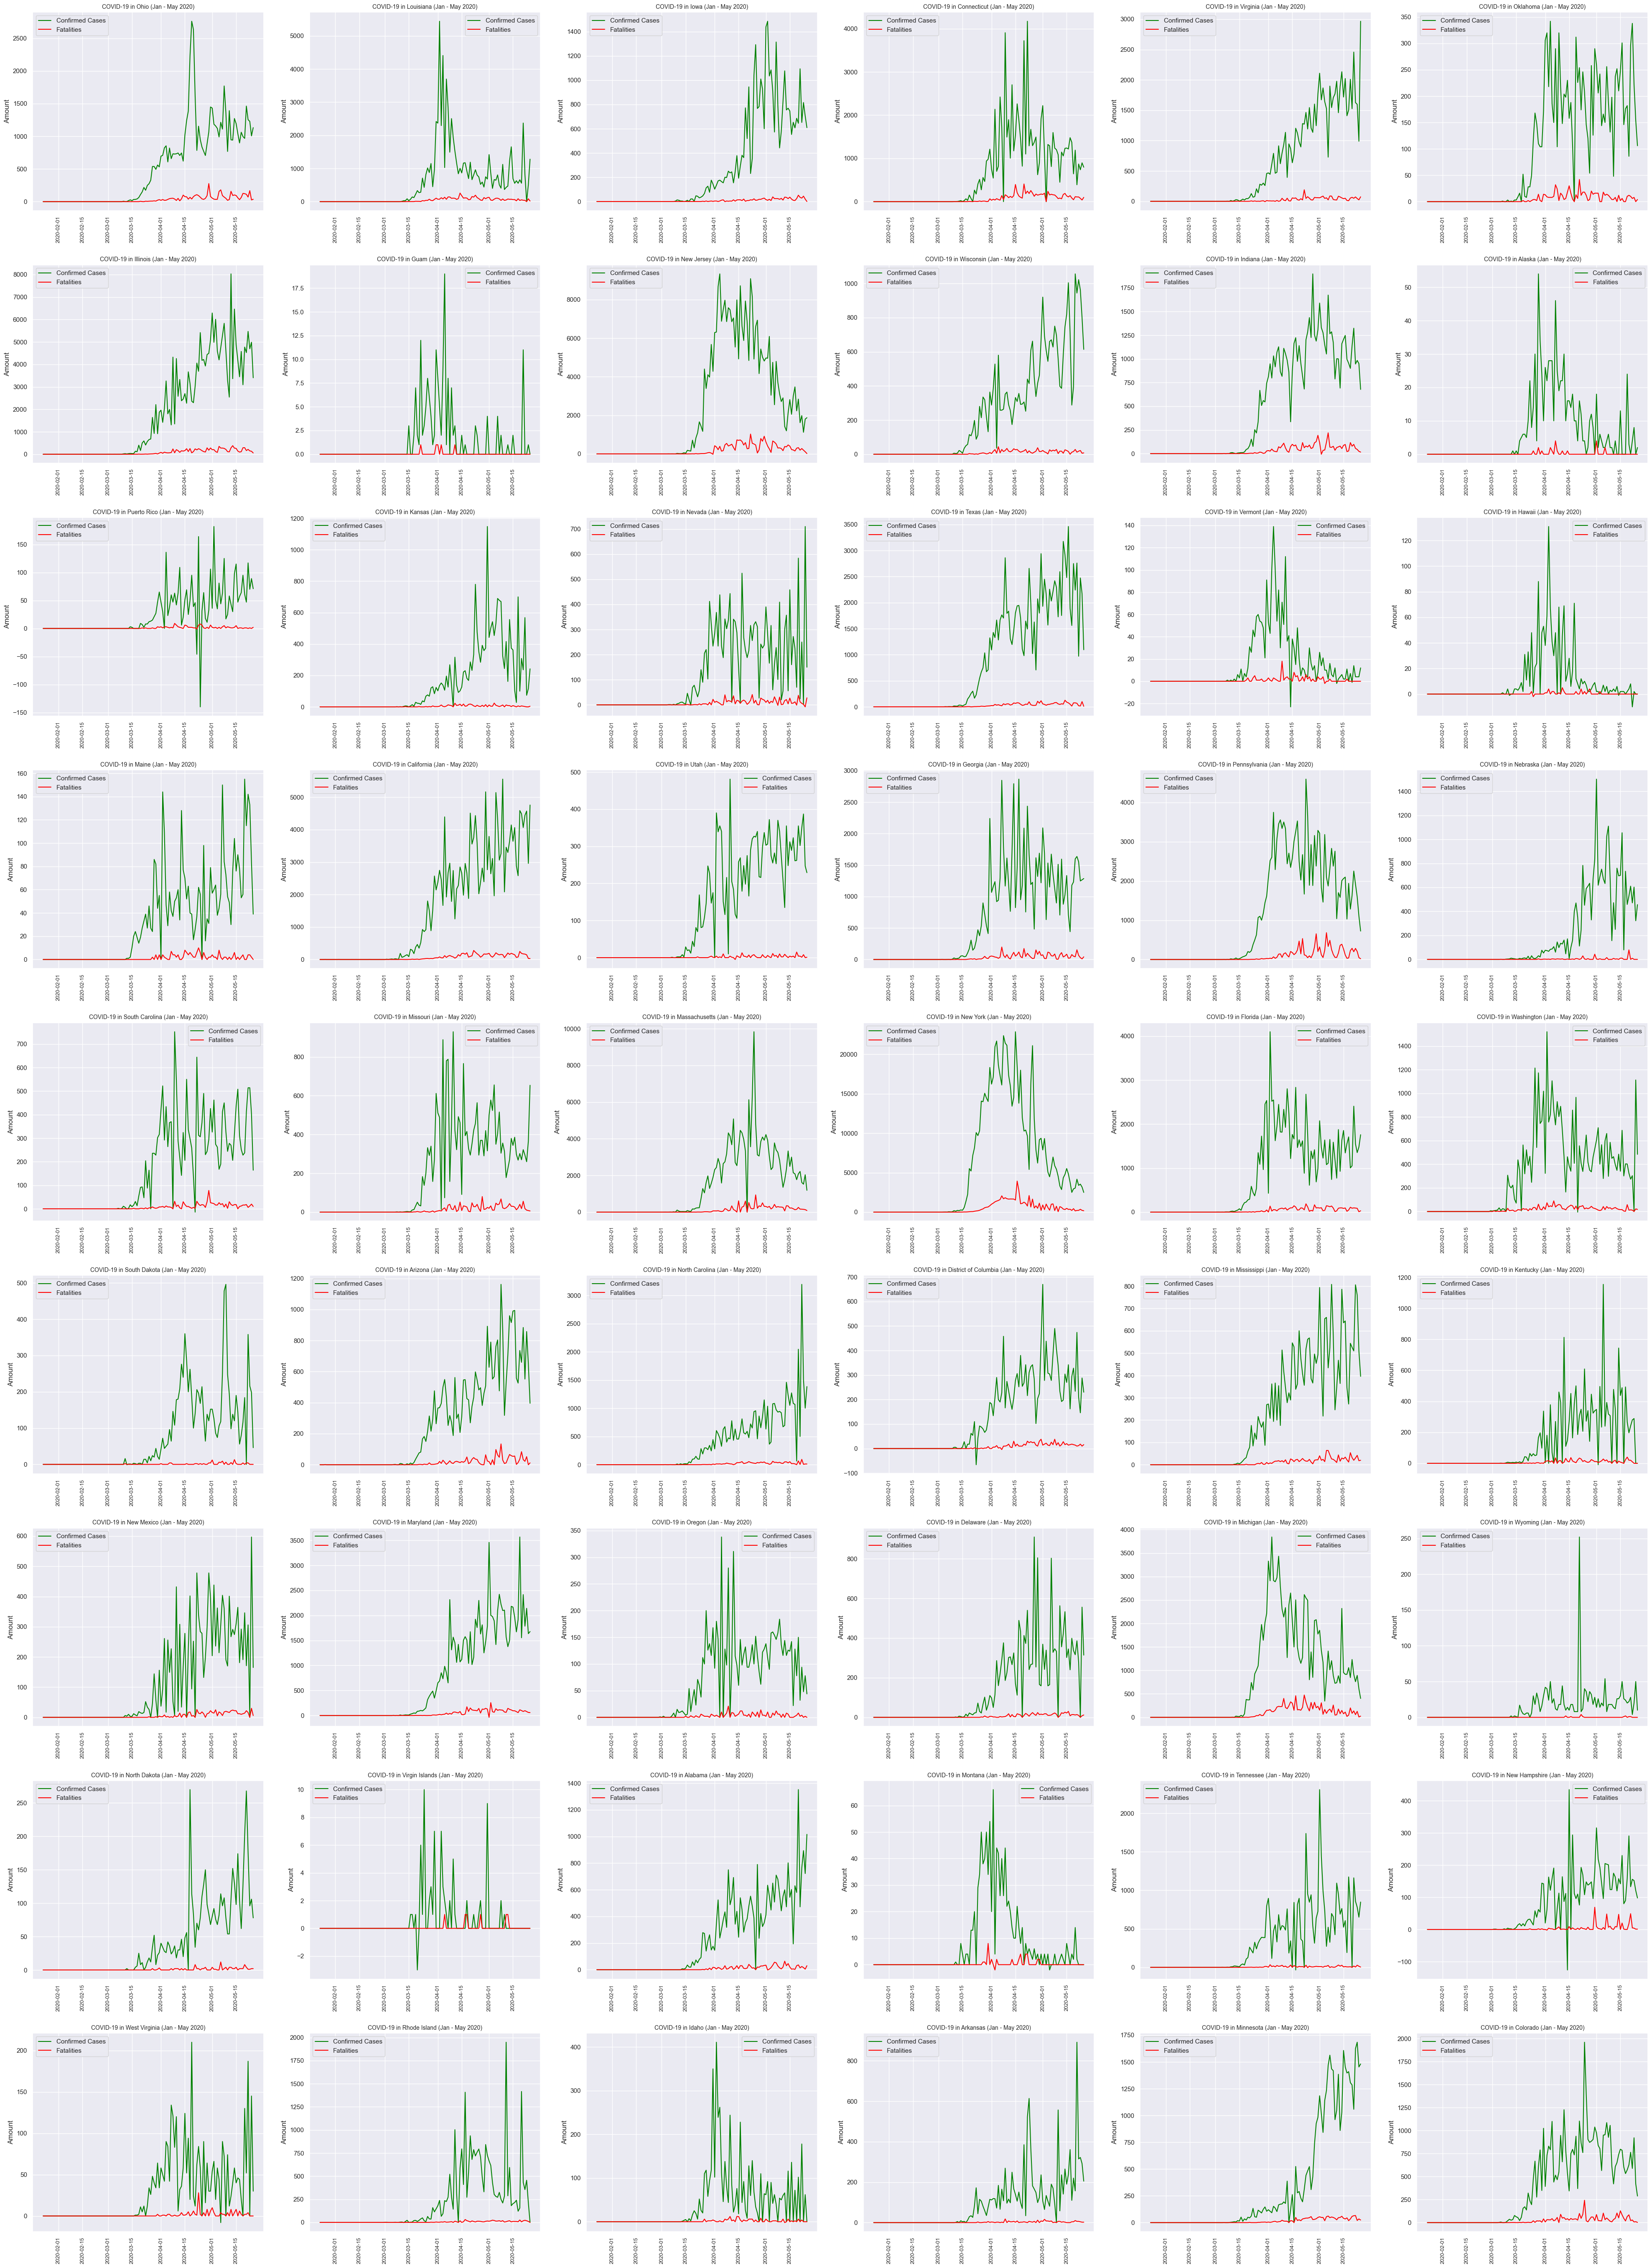

In [194]:
State=list(set(df[df.Country_Region=="US"].Province_State))[1:]
plt.figure(figsize=(40,60))
for i in range(len(State)):
    plt.subplot(10,6,i+1)
    c=us_confirm[us_confirm.Province_State==State[i]].groupby('Date')['TargetValue'].sum().reset_index()
    f=us_death[us_death.Province_State==State[i]].groupby('Date')['TargetValue'].sum().reset_index()
    plt.plot(c.Date,c.TargetValue,label='Confirmed Cases',color='green')
    plt.plot(f.Date,f.TargetValue,label='Fatalities',color='red')
    plt.legend(loc='best')
    plt.title('COVID-19 in {} (Jan - May 2020)'.format(State[i]),size=10)
    plt.xticks(rotation=90,size=9)
    plt.tight_layout(pad=2.0)
    plt.ylabel('Amount')
plt.savefig("figures/provincewise_covid19")

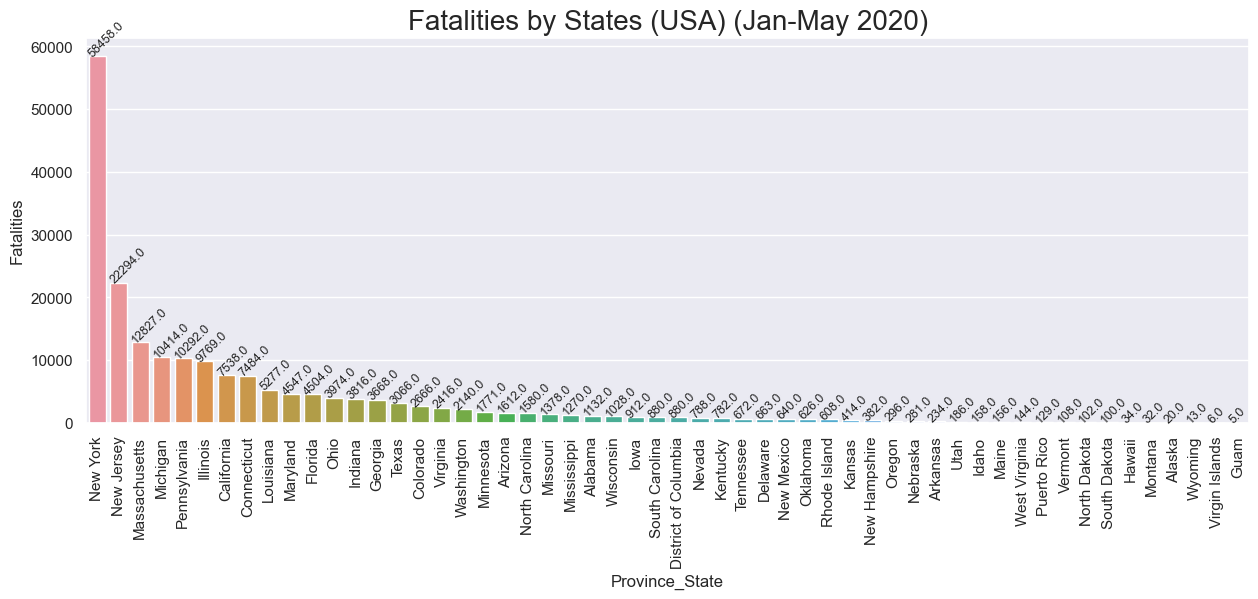

In [186]:
total_fatality=pd.DataFrame(us_death.groupby('Province_State')['TargetValue'].sum()).sort_values(by='TargetValue',ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=total_fatality.index,y=total_fatality.TargetValue)
plt.ylabel('Fatalities')
plt.xticks(rotation=90)
plt.title('Fatalities by States (USA) (Jan-May 2020)',fontsize=20)
for i in range(len(total_fatality.index)):
    plt.text(i-0.5,total_fatality.TargetValue[i]+1,"{}".format(total_fatality.TargetValue[i]),size=9,rotation=45)
# plt.show()
plt.savefig("figures/Fatalities by States (USA) (Jan-May 2020)")

In [127]:
df_confirm=df[df.Country_Region=="US"][df[df.Country_Region=="US"].Target=='ConfirmedCases'].groupby(['Province_State','County'])['TargetValue'].sum().reset_index()
df_fatality=df[df.Country_Region=="US"][df[df.Country_Region=="US"].Target=='Fatalities'].groupby(['Province_State','County'])['TargetValue'].sum().reset_index()
usa=pd.merge(df_confirm,df_fatality,on=['Province_State','County'])
usa.columns=['name','county', 'Confirmed_Cases','Fatalities']

In [128]:
usa_states=usa.groupby('name')[['Confirmed_Cases','Fatalities']].sum().reset_index()
usa_location=pd.read_csv(path+'usa_State_locaiton.csv')
usa_map_df=pd.merge(usa_states,usa_location,on='name')
usa_map_df.columns=['NAME', 'Confirmed_Cases', 'Fatalities', 'code', 'latitude','longitude']
usa_map_df=usa_map_df[usa_map_df.NAME!='Hawaii']
usa_map_df=usa_map_df[usa_map_df.NAME!='Alaska']

In [129]:
# cb_2018_us_state_20m shapefile
geo_usa = geopandas.read_file(path+'cb_2018_us_state_20m')
geo_merge=geo_usa.merge(usa_map_df,on='NAME')

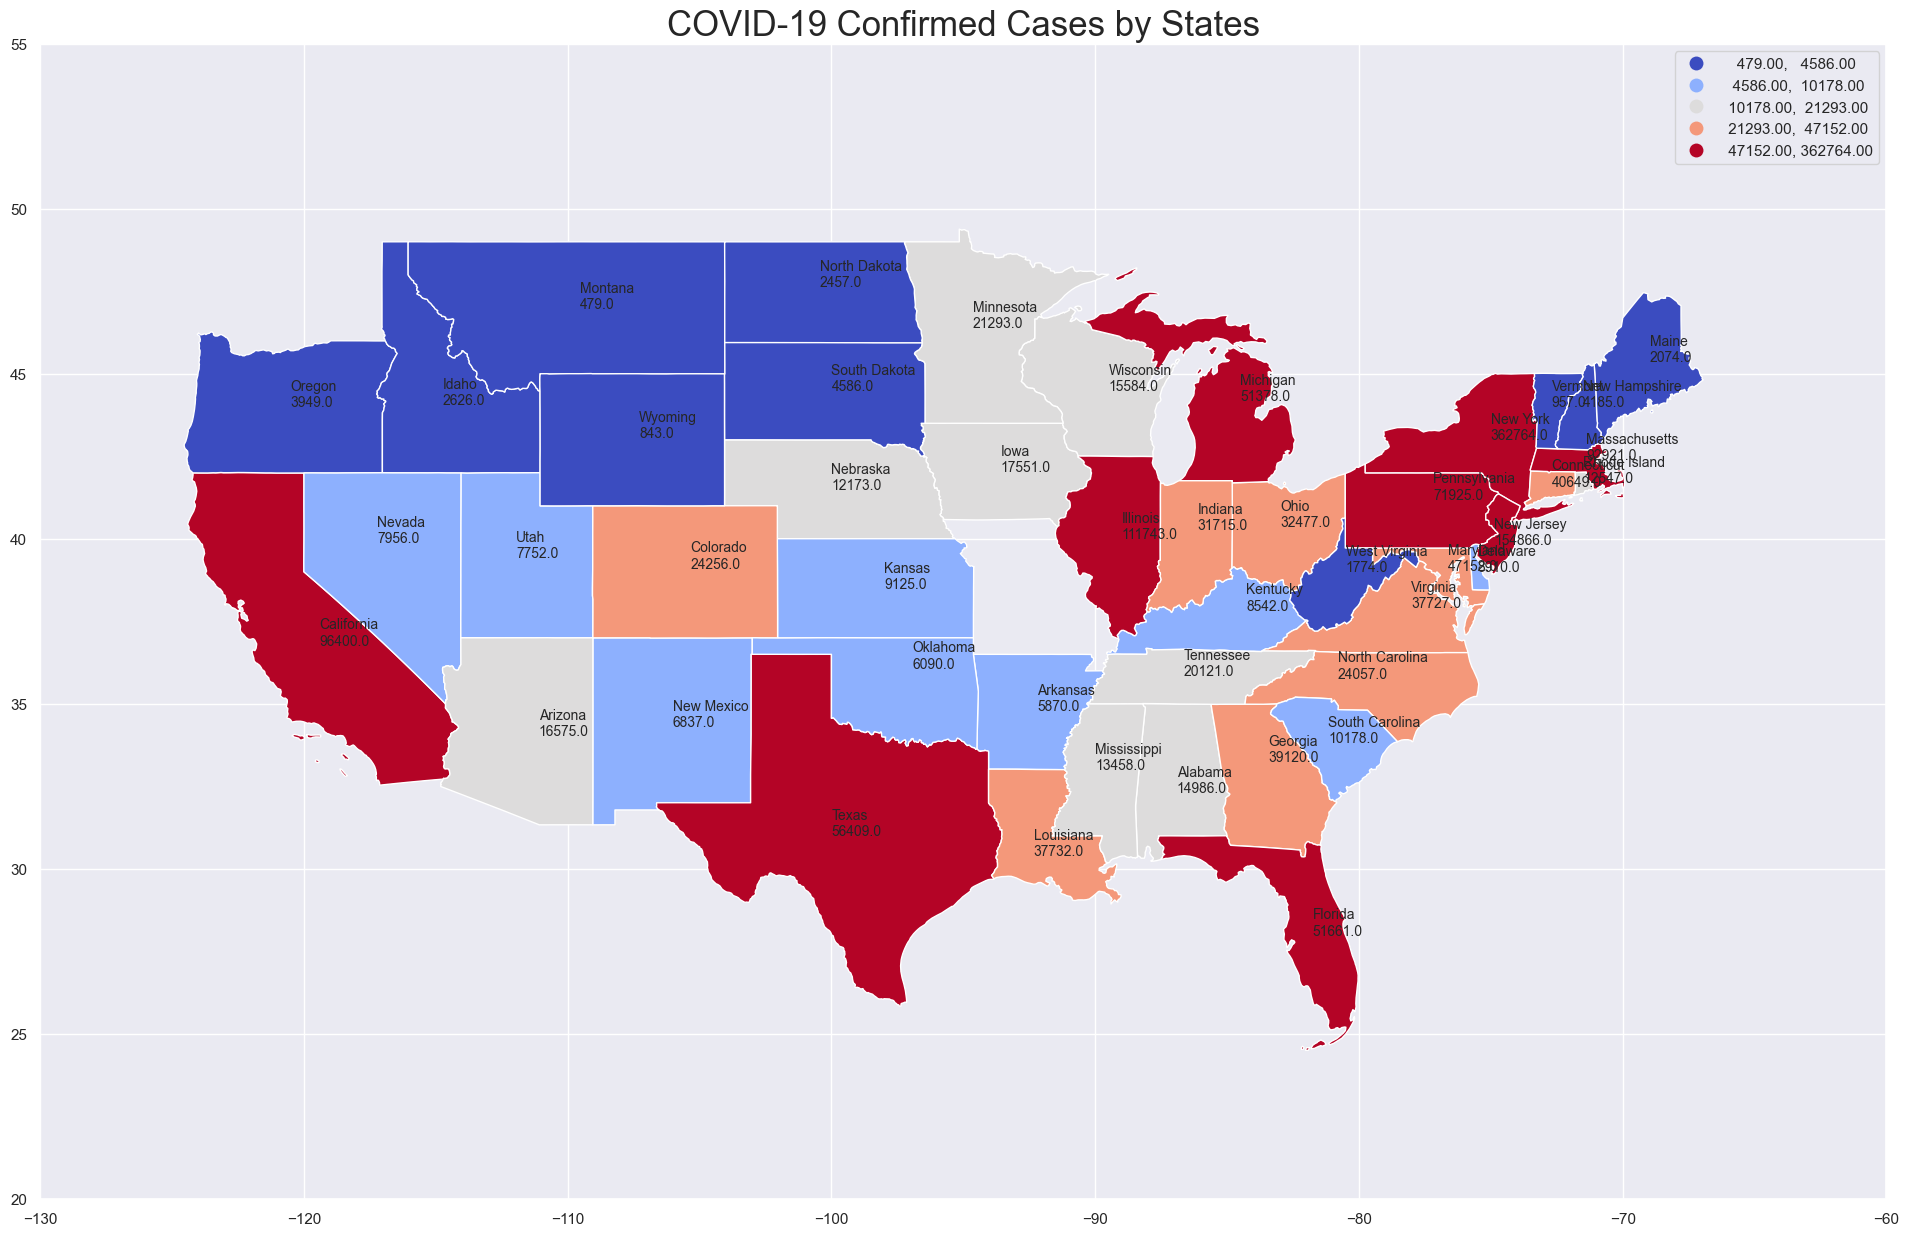

In [187]:
geo_merge.plot(column='Confirmed_Cases', scheme="quantiles",figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
for i in range(len(geo_merge)):
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n{}".format(geo_merge.NAME[i],geo_merge.Confirmed_Cases[i]),size=10)
plt.title('COVID-19 Confirmed Cases by States',fontsize=25)
# plt.show()
plt.savefig('figures/COVID-19 Confirmed Cases by States')

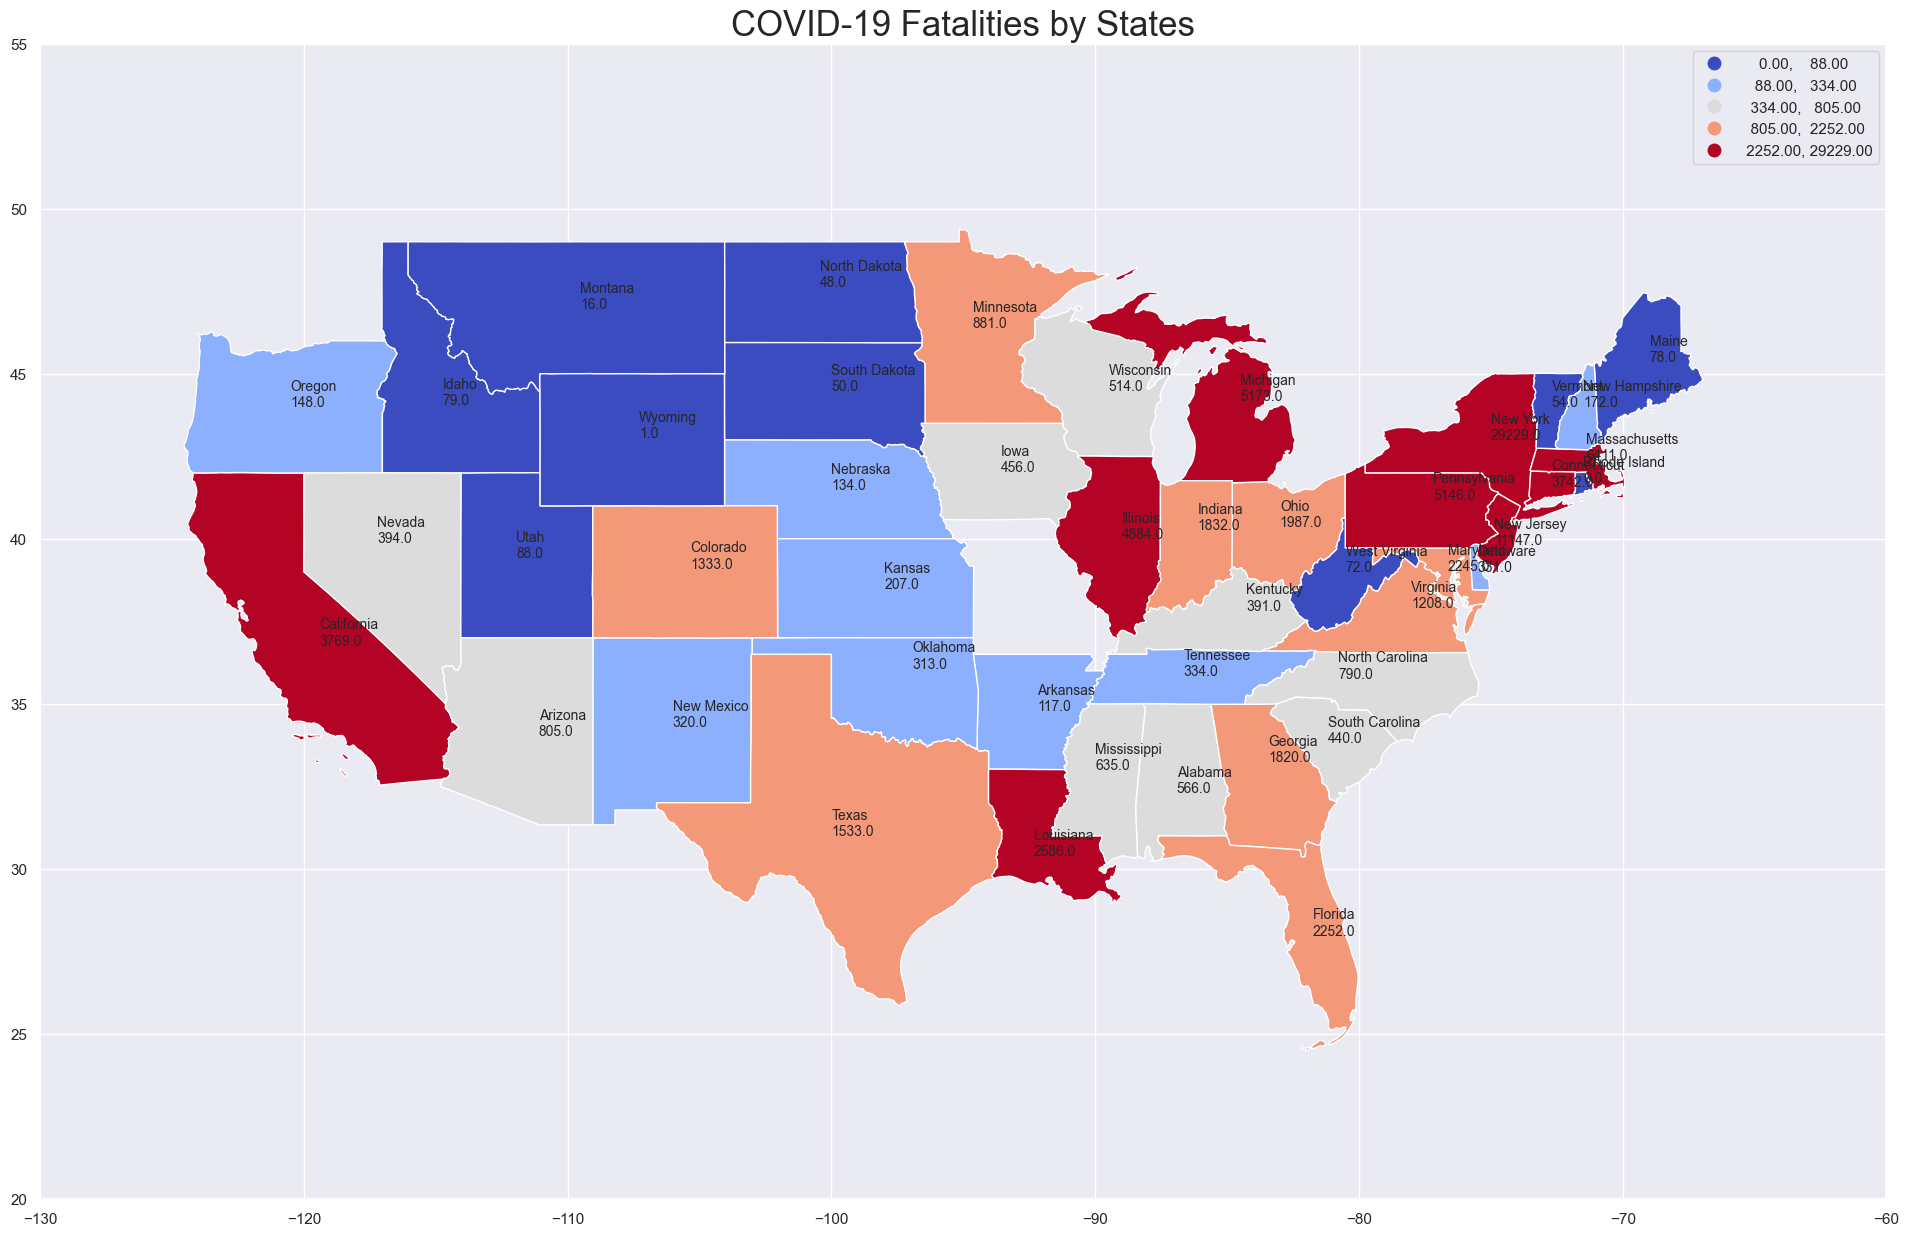

In [131]:
geo_merge.plot(column='Fatalities', scheme="quantiles",figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
for i in range(len(geo_merge)):
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n{}".format(geo_merge.NAME[i],geo_merge.Fatalities[i]),size=10)
plt.title('COVID-19 Fatalities by States',fontsize=25)
plt.show()

#### Let us analyze New York City

In [132]:
nyc_link=path+'boroughs-case-hosp-death.csv'
nyc=pd.read_csv(nyc_link)
nyc['Date']=pd.to_datetime(nyc.DATE_OF_INTEREST)

In [133]:
nyc.head()

DATE_OF_INTEREST  MN_CASE_COUNT  MN_HOSPITALIZED_COUNT  MN_DEATH_COUNT  \
0       02/29/2020              1                      0               0   
1       03/03/2020              0                      0               0   
2       03/04/2020              2                      1               0   
3       03/05/2020              0                      3               0   
4       03/06/2020              3                      1               0   

   QN_CASE_COUNT  QN_HOSPITALIZED_COUNT  QN_DEATH_COUNT  BK_CASE_COUNT  \
0              0                      0               0              0   
1              1                      1               0              0   
2              2                      0               0              1   
3              0                      3               0              3   
4              1                      1               0              1   

   BK_HOSPITALIZED_COUNT  BK_DEATH_COUNT  BX_CASE_COUNT  \
0                      0               0              0   
1                      0               0              0   
2                      1               0              0   
3                      2               0              0   
4                      1               0              2   

   BX_HOSPITALIZED_COUNT  BX_DEATH_COUNT  SI_CASE_COUNT  \
0                      0               0              0   
1                      0               0              0   
2                      0               0              0   
3                      0               0              0   
4                      1               0              1   

   SI_HOSPITALIZED_COUNT  SI_DEATH_COUNT       Date  
0                      0               0 2020-02-29  
1                      0               0 2020-03-03  
2                      0               0 2020-03-04  
3                      0               0 2020-03-05  
4                      1               0 2020-03-06

In [134]:
boroughs=[['BK_CASE_COUNT', 'BK_DEATH_COUNT'], 
          ['BX_CASE_COUNT', 'BX_DEATH_COUNT'], 
          ['MN_CASE_COUNT',  'MN_DEATH_COUNT'], 
          ['QN_CASE_COUNT', 'QN_DEATH_COUNT'], 
          ['SI_CASE_COUNT',  'SI_DEATH_COUNT']]

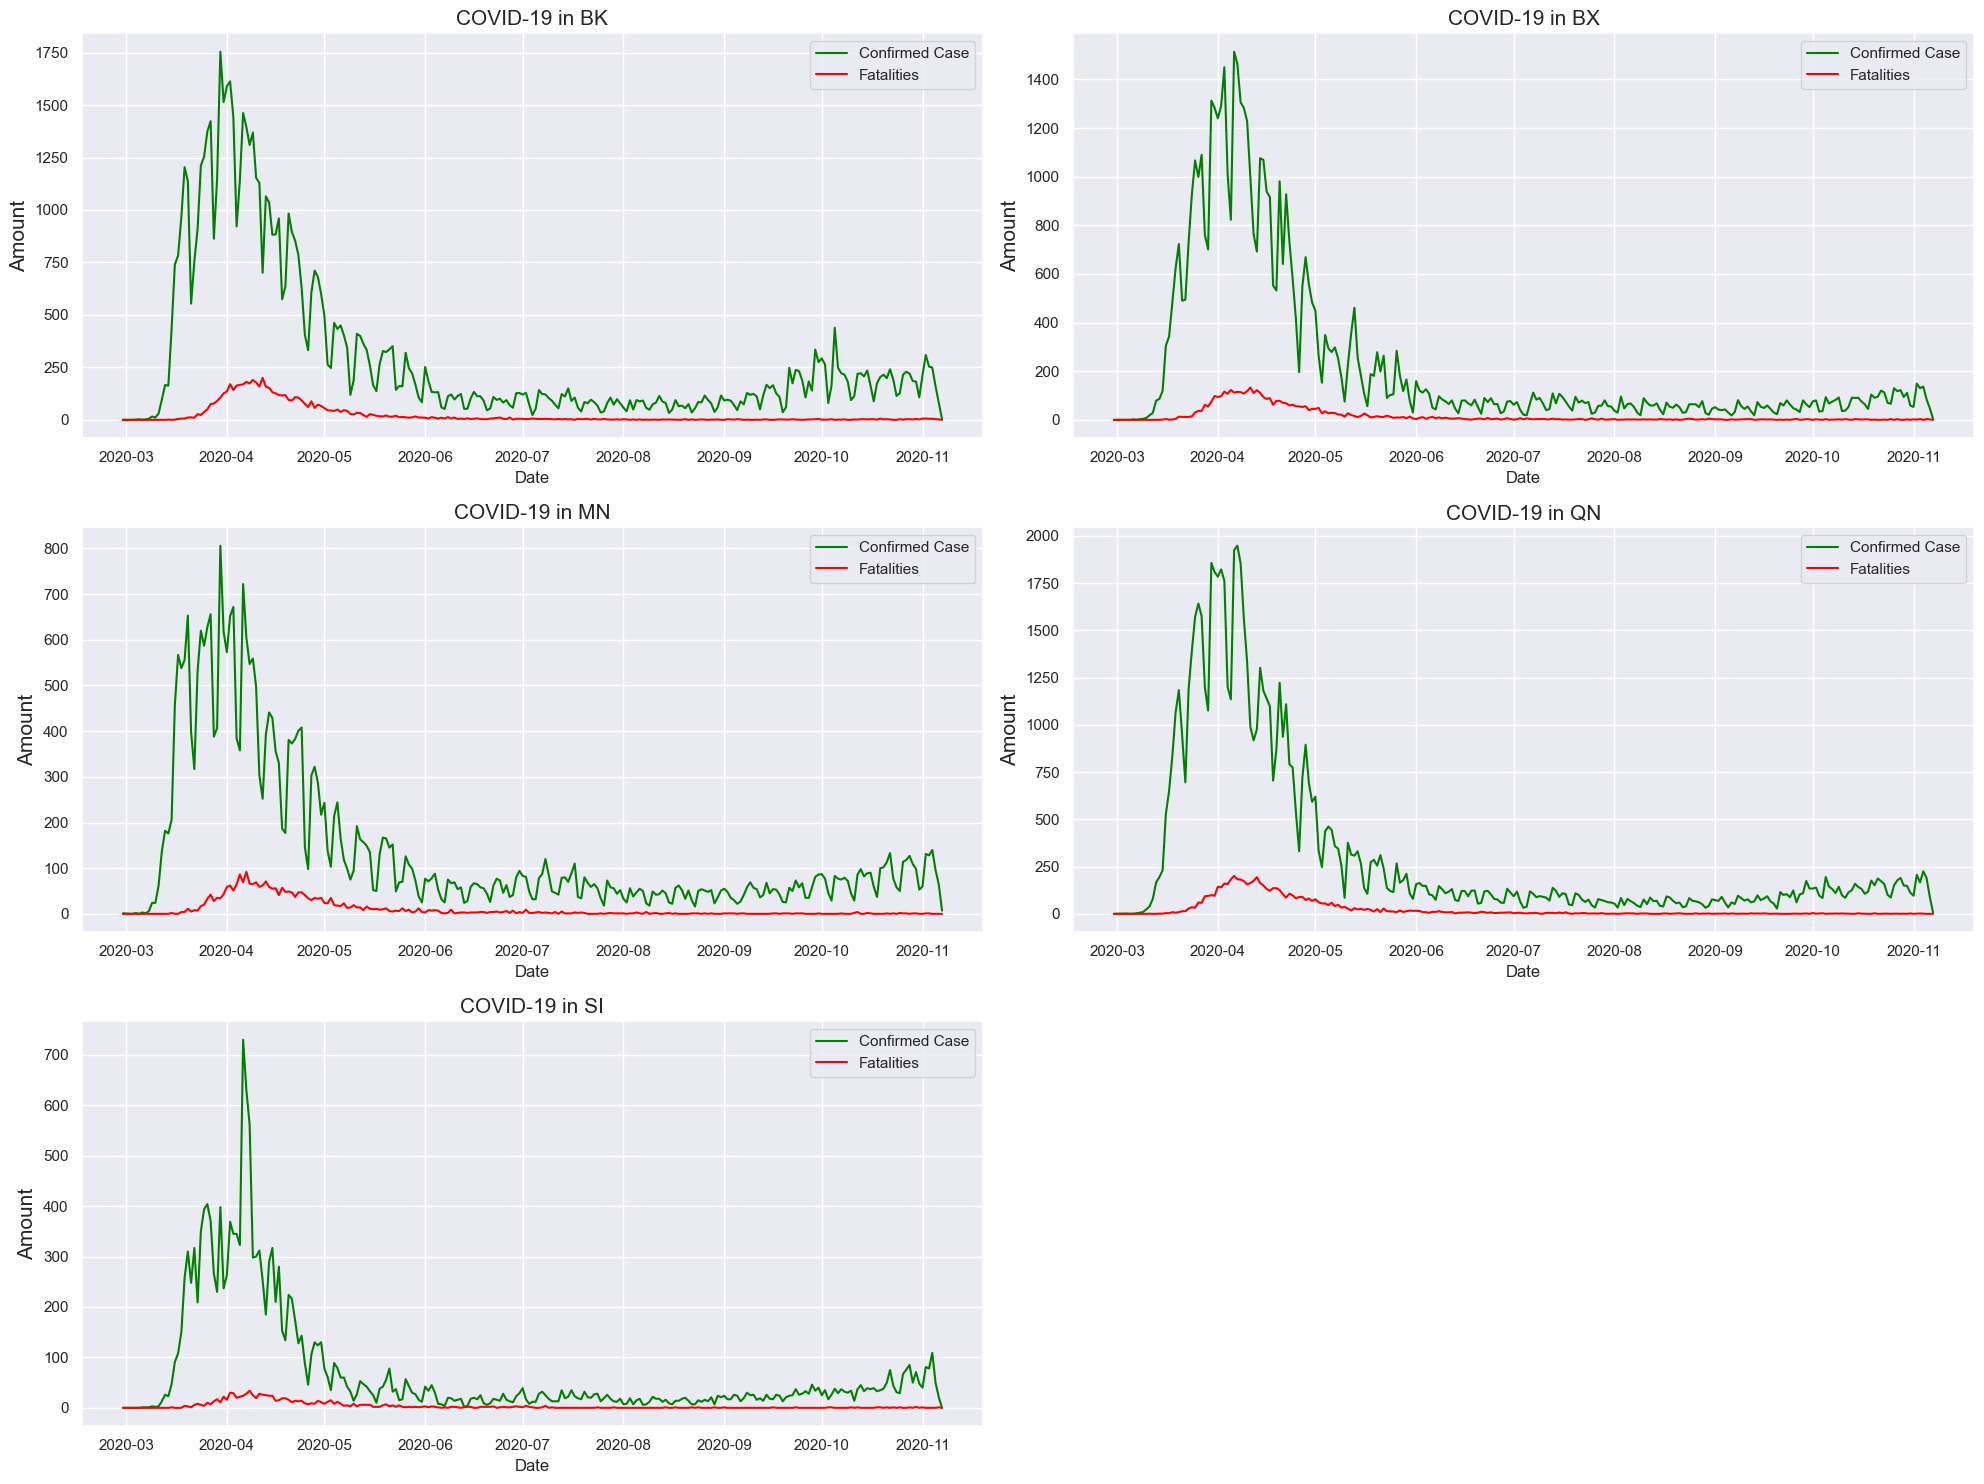

In [193]:
plt.figure(figsize=(20,15))
for i in range(len(boroughs)):
    plt.subplot(3,2,i+1)
    sns.lineplot(x=nyc.Date,y=nyc[boroughs[i][0]],color='green',label='Confirmed Case')
    sns.lineplot(x=nyc.Date,y=nyc[boroughs[i][1]],color='red',label='Fatalities')
    plt.ylabel('Amount',fontsize=15)
    plt.xticks()
    plt.tight_layout()
    plt.title('COVID-19 in {}'.format(boroughs[i][0][:2]),fontsize=15)
plt.savefig("figures/Statewise_coid19_lineplot")

In [136]:
nyc_con=[]
nyc_fa=[]
for i in boroughs:
    nyc_con.append(sum(nyc[i[0]]))
    nyc_fa.append(sum(nyc[i[1]]))

In [137]:
nyc_shp = geopandas.read_file(geopandas.datasets.get_path('nybb'))
con_fa_nyc=pd.DataFrame()
con_fa_nyc['BoroName']=['Brooklyn','Bronx','Manhattan','Queens','Staten Island']
con_fa_nyc['Confirmed_Cases']=nyc_con
con_fa_nyc['Fatalities']=nyc_fa
con_fa_nyc['longitude']=[985000,1000000,970000 ,1040000,925000]
con_fa_nyc['latitude']=[180000,250000,220000,200000,150000]
nyc_shp=nyc_shp.merge(con_fa_nyc,on='BoroName')
nyc_shp.head()

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  Confirmed_Cases  \
0  MULTIPOLYGON (((970217.022 145643.332, 970227....            17555   
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...            77519   
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...            75509   
3  MULTIPOLYGON (((981219.056 188655.316, 980940....            34702   
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...            56521   

   Fatalities  longitude  latitude  
0         916     925000    150000  
1        6049    1040000    200000  
2        5776     985000    180000  
3        2548     970000    220000  
4        4070    1000000    250000

#### Let us do EDA based on Race, Age, Sex, Poverty

In [143]:
race=pd.read_csv('C:/Users/shaur/Desktop/CV Projects/Time Series Project/Time_Series_Covid_19_Project/data/by-race.csv')
age=pd.read_csv('C:/Users/shaur/Desktop/CV Projects/Time Series Project/Time_Series_Covid_19_Project/data/by-age.csv')
sex=pd.read_csv('C:/Users/shaur/Desktop/CV Projects/Time Series Project/Time_Series_Covid_19_Project/data/by-sex.csv')
poverty=pd.read_csv('C:/Users/shaur/Desktop/CV Projects/Time Series Project/Time_Series_Covid_19_Project/data/by-poverty.csv')

#### Analysis based on Race

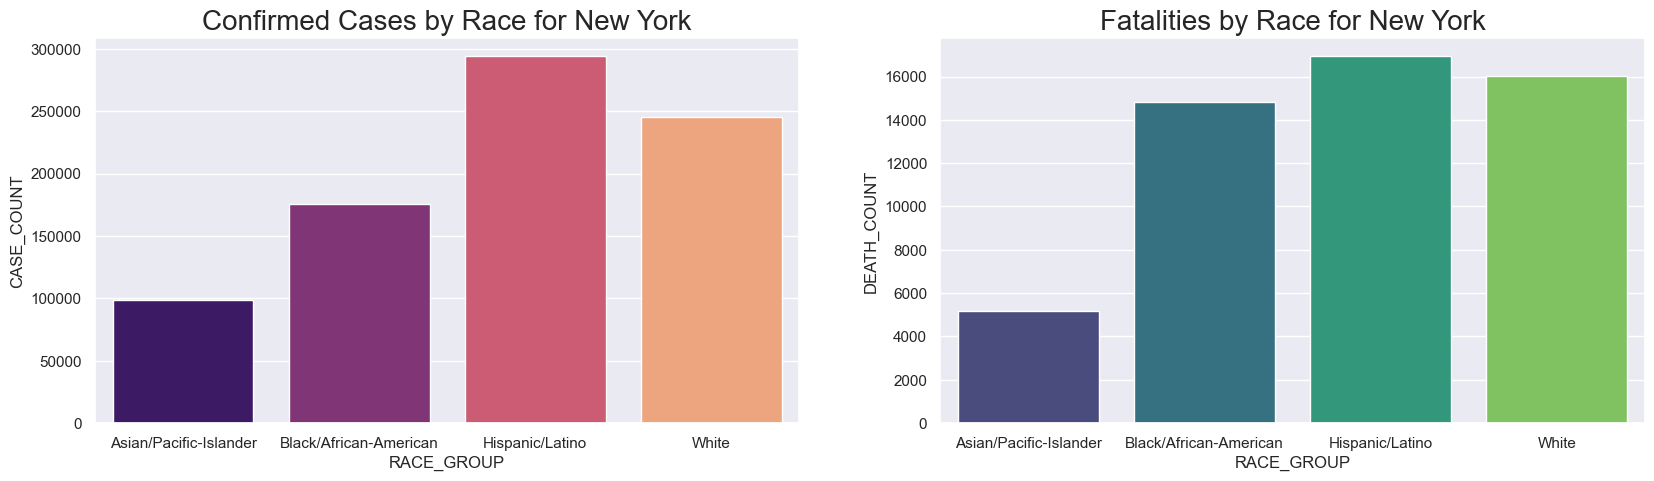

In [192]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(x=race.RACE_GROUP,y=race.CASE_COUNT, palette='magma')
plt.title('Confirmed Cases by Race for New York',fontsize=20)
plt.subplot(1,2,2)
sns.barplot(x=race.RACE_GROUP,y=race.DEATH_COUNT, palette='viridis')
plt.title('Fatalities by Race for New York',fontsize=20)

# plt.show()
plt.savefig("figures/race")

#### Analysis based on Age

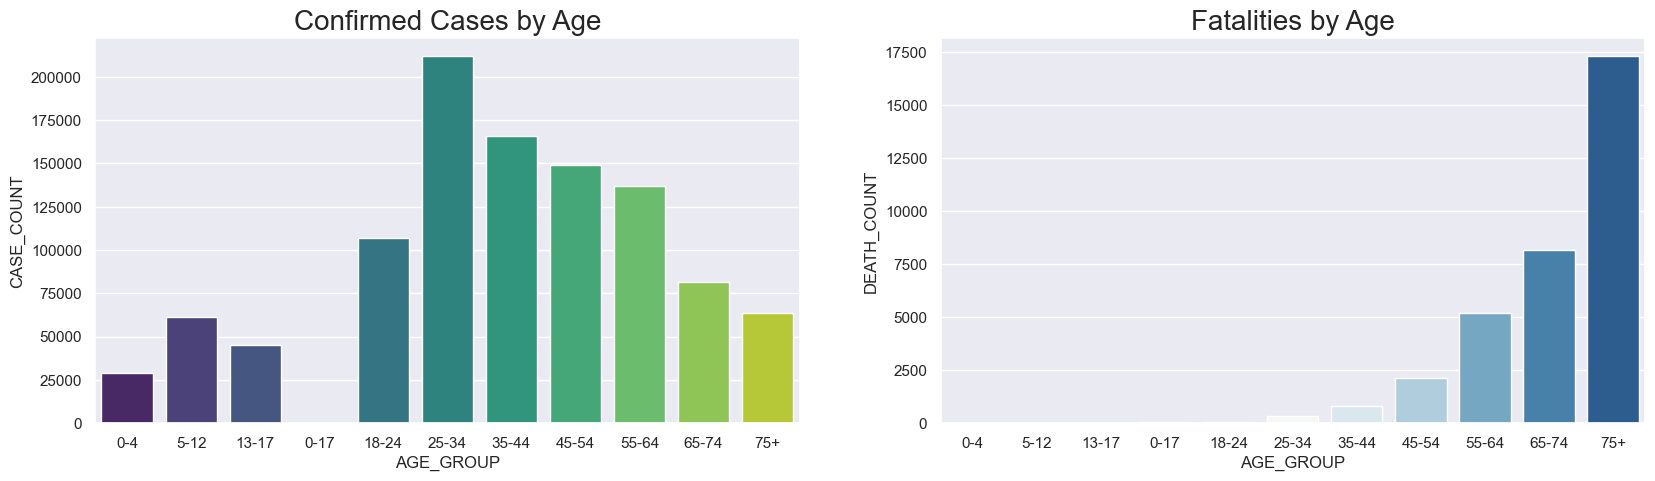

In [191]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(x=age.iloc[:-1].AGE_GROUP,y=age.iloc[:-1].CASE_COUNT, palette='viridis')
plt.title('Confirmed Cases by Age',fontsize=20)
plt.subplot(1,2,2)
sns.barplot(x=age.iloc[:-1].AGE_GROUP,y=age.iloc[:-1].DEATH_COUNT, palette='RdBu')
plt.title('Fatalities by Age',fontsize=20)

# plt.show()
plt.savefig("figures/age")

#### Analysis based on Gender

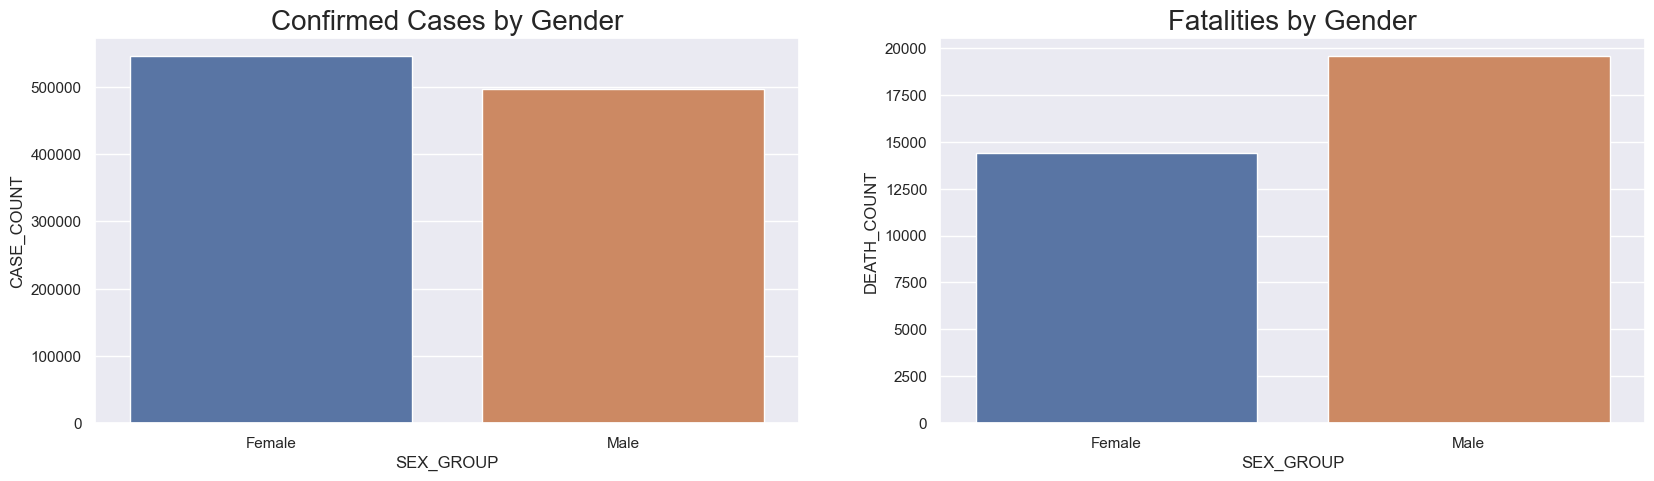

In [190]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(x=sex.iloc[:-1].SEX_GROUP,y=sex.iloc[:-1].CASE_COUNT)
plt.title('Confirmed Cases by Gender',fontsize=20)
plt.subplot(1,2,2)
sns.barplot(x=sex.iloc[:-1].SEX_GROUP,y=sex.iloc[:-1].DEATH_COUNT)
plt.title('Fatalities by Gender',fontsize=20)


# plt.show()
plt.savefig("figures/gender")

#### Analysis based on Poverty

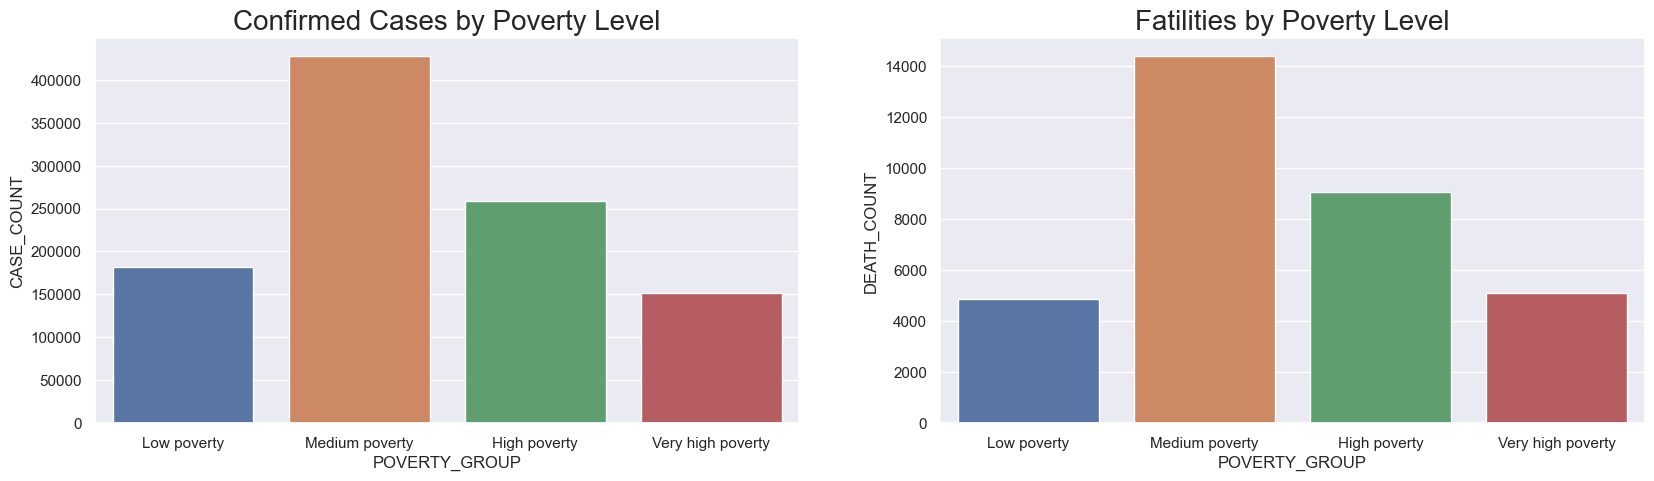

In [189]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(x=poverty.POVERTY_GROUP,y=poverty.CASE_COUNT)
plt.title('Confirmed Cases by Poverty Level',fontsize=20)
plt.subplot(1,2,2)
sns.barplot(x=poverty.POVERTY_GROUP,y=poverty.DEATH_COUNT)
plt.title('Fatilities by Poverty Level',fontsize=20)
# plt.show()
plt.savefig('figures/poverty_level')